In [ ]:
# Load in required libraries
%matplotlib inline
import os
import os.path as op
import numpy as np
import cv2
import matplotlib.pylab as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Better results so far**

include cropping

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to load images with error handling
def load_images(image_paths):
    images = []
    invalid_paths = []

    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:
            images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            invalid_paths.append(path)

    if invalid_paths:
        print(f"Warning: Unable to load the following images:\n{invalid_paths}")

    return images


# Function to display images with titles
def display_images(images, titles, cols=4, figsize=(15, 10), max_per_page=12):
    """
    Display a maximum of 12 images in a grid with their corresponding titles.

    Parameters:
        images (list): List of images to display.
        titles (list): List of titles corresponding to each image.
        cols (int): Number of columns in the grid. Default is 4.
        figsize (tuple): Figure size for the plot. Default is (15, 10).
        max_per_page (int): Maximum number of images to display. Default is 12.
    """
    # Limit the number of images to max_per_page (12)
    total_images = min(len(images), max_per_page)

    # Create a subset of images for display
    subset_images = images[:total_images]
    subset_titles = titles[:total_images]

    # Dynamically calculate rows for this subset
    rows = (total_images + cols - 1) // cols

    # Create the figure
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    # Display each image in the grid
    for i, img in enumerate(subset_images):
        ax = axes[i]
        ax.imshow(img, cmap="gray" if len(img.shape) == 2 else None)
        ax.set_title(subset_titles[i], size=12)
        ax.axis("off")

    # Turn off unused axes if there are fewer than cols * rows images
    for i in range(total_images, len(axes)):
        axes[i].axis("off")

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


# Convert images to grayscale
def convert_to_grayscale(images):
    grayscale_images = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images]
    return grayscale_images


# Apply vertical kernel and median filter for noise removal
def remove_salt_pepper(images):
    filtered_images = []
    for img in images:
        vertical_blur = cv2.blur(img, (1, 7))  # Vertical blur
        filtered_img = cv2.medianBlur(vertical_blur, 3)  # Median filter
        filtered_images.append(filtered_img)
    return filtered_images

# Calculate Sobel gradients
def calculate_gradients(grayscale_images, ksize=3):
    gradient_images = []
    for img in grayscale_images:
        grad_x = cv2.Sobel(img, cv2.CV_8UC1, 1, 0, ksize=ksize)
        grad_y = cv2.Sobel(img, cv2.CV_8UC1, 0, 1, ksize=ksize)
        gradient = cv2.subtract(grad_x, grad_y)
        gradient = cv2.convertScaleAbs(gradient)
        gradient_images.append(gradient)
    return gradient_images


# Threshold the images using Otsu's method
def threshold_images(gradient_images):
    otsu_thresh_images = []
    for img in gradient_images:
        _, otsu_thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        otsu_thresh_images.append(otsu_thresh)
    return otsu_thresh_images


# Perform morphological operations for cleanup
def clean_images(threshold_images):
    cleaned_images = []
    struct = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    for img in threshold_images:
        closed_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, struct)
        erosion_img = cv2.erode(closed_img, None, iterations=5)
        dilation_img = cv2.dilate(erosion_img, None, iterations=10)
        cleaned_images.append(dilation_img)
    return cleaned_images


# Detect barcodes and draw bounding boxes, return bounding box coordinates
def detect_barcodes(cleaned_images, original_images):
    final_images = []
    bounding_boxes = []

    for i, img in enumerate(cleaned_images):
        contours, _ = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not contours:
            print(f"No contours found in image {i+1}. Skipping this image.")
            final_images.append(original_images[i])
            bounding_boxes.append(None)
            continue

        # Sort contours by area and use the largest one
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        rotated_bounding_box = cv2.minAreaRect(contours[0])
        bounding_box_points = cv2.boxPoints(rotated_bounding_box)
        bounding_box_points = np.intp(bounding_box_points)

        # Draw the bounding box on the image
        img_with_box = cv2.drawContours(original_images[i].copy(), [bounding_box_points], -1, (0, 0, 255), 3)
        final_images.append(img_with_box)

        # Extract bounding box coordinates for cropping
        x, y, w, h = cv2.boundingRect(contours[0])  # (x, y) is the top-left, (w, h) are width and height
        bounding_boxes.append((x, y, w, h))
# Return final images and bounding box coordinates
    return final_images, bounding_boxes

In [ ]:
# Crop barcodes using bounding box coordinates
def crop_barcodes(original_images, bounding_boxes):
    cropped_barcodes = []

    for i, (image, bbox) in enumerate(zip(original_images, bounding_boxes)):
        if bbox is None:
            print(f"No bounding box found for image {i+1}. Skipping this image.")
            cropped_barcodes.append(None)  # No barcode detected
            continue

        x, y, w, h = bbox
        cropped_barcode = image[y:y+h, x:x+w]  # Crop using bounding box
        cropped_barcodes.append(cropped_barcode)
    return cropped_barcodes



# Example image paths
image_paths = [
    "/content/drive/MyDrive/Colab Notebooks/Barcodes/bar_code1.png",
    "/content/drive/MyDrive/Colab Notebooks/Barcodes/bar_code2.png",
    "/content/drive/MyDrive/Colab Notebooks/Barcodes/bar_code3.png",
    "/content/drive/MyDrive/Colab Notebooks/Barcodes/bar_code4.png",
    "/content/drive/MyDrive/Colab Notebooks/Barcodes/bar_code5.png",
    "/content/drive/MyDrive/Colab Notebooks/Barcodes/bar_code6.png",
    "/content/drive/MyDrive/Colab Notebooks/Barcodes/bar_code7.png",
    "/content/drive/MyDrive/Colab Notebooks/Barcodes/bar_code8.png",
    "/content/drive/MyDrive/Colab Notebooks/Barcodes/bar_code9.png",
    "/content/drive/MyDrive/Colab Notebooks/Barcodes/bar_code10.png",
    "/content/drive/MyDrive/Colab Notebooks/Barcodes/bar_code11.png",
    "/content/drive/MyDrive/Colab Notebooks/Barcodes/bar_code12.png"
]

In [ ]:
def apply_highpass_filter(image_list, limit, gaussian=False, keep_dc=False):
    def create_circle_mask(mask_size, radius):
        mask = np.zeros(mask_size)
        cy = mask.shape[0] // 2
        cx = mask.shape[1] // 2
        return cv2.circle(mask, (cx, cy), radius, (255, 255, 255), -1).astype(np.uint8)

    processed_images = []

    for dft_img in image_list:
        # Create the high-pass filter mask
        mask = ~create_circle_mask(dft_img.shape, limit)
        if gaussian:
            mask = cv2.GaussianBlur(mask, (21, 21), 0)
        if keep_dc:
            mask[dft_img.shape[0] // 2, dft_img.shape[1] // 2] = 255

        # Apply the mask to the shifted DFT image
        dft_img_shifted = np.fft.fftshift(dft_img)
        dft_img_shifted_highpass = np.multiply(dft_img_shifted, mask)

        # Perform the inverse FFT to reconstruct the image
        img_reconstructed = np.fft.ifft2(np.fft.ifftshift(dft_img_shifted_highpass))
        img_processed = np.abs(img_reconstructed)

        processed_images.append(img_processed)

    return processed_images

In [ ]:
def detect_barcodes_with_orientation_and_axis(cleaned_images, original_images):
    final_images = []
    bounding_boxes = []
    orientations = []  # To store barcode orientation info

    for i, img in enumerate(cleaned_images):
        contours, _ = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not contours:
            print(f"No contours found in image {i+1}. Skipping this image.")
            final_images.append(original_images[i])
            bounding_boxes.append(None)
            orientations.append("No Barcode")
            continue

        # Sort contours by area and use the largest one
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        rotated_bounding_box = cv2.minAreaRect(contours[0])
        bounding_box_points = cv2.boxPoints(rotated_bounding_box)
        bounding_box_points = np.intp(bounding_box_points)

        # Draw the bounding box on the image
        img_with_box = original_images[i].copy()
        #cv2.drawContours(img_with_box, [bounding_box_points], -1, (0, 0, 255), 3)

        # Calculate the orientation angle
        center = tuple(map(int, rotated_bounding_box[0]))  # Center of the bounding box
        width, height = rotated_bounding_box[1]

        # Calculate the orientation angle
        angle = rotated_bounding_box[-1]
        if width > height:
            angle = angle + 90 if angle < -45 else angle
        else:
            angle = angle - 90 if angle > 45 else angle

        # Append the image with bounding box
        final_images.append(img_with_box)

        # Extract bounding box coordinates for cropping
        x, y, w, h = cv2.boundingRect(contours[0])  # (x, y) is the top-left, (w, h) are width and height
        bounding_boxes.append((x, y, w, h))

        # Determine orientation
        if abs(angle) <= 5 or abs(angle) >= 85:  # Treat angles close to 0° or ±90° as straight
            orientation = "Straight"
        else:
            orientation = "Tilted"
              # Straighten the tilted image
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            rotated_img = cv2.warpAffine(original_images[i], rotation_matrix, (original_images[i].shape[1], original_images[i].shape[0]), borderValue=(255, 255, 255))

            # Replace the image in final_images with the straightened one
            final_images[-1] = rotated_img

        orientations.append(f"Orientation: {orientation}, Angle: {angle:.2f}°")

    return final_images, bounding_boxes, orientations


In [ ]:

# Apply manual thresholding and Otsu's method
def threshold_images1(blurred_images):
    manual_thresh_img = []
    for img in blurred_images:
        # Manual Thresholding
        _, manual_threshed = cv2.threshold(img, 110, 255, cv2.THRESH_BINARY)
        manual_thresh_img.append(manual_threshed)

    return manual_thresh_img

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
def give_me_circle_mask_nowww(mask_size, radius):
    # Ensure the mask is a single-channel grayscale image, with dtype=np.uint8
    mask = np.zeros(mask_size, dtype=np.uint8)  # Single channel mask

    # Find the center of the mask
    cy = mask.shape[0] // 2
    cx = mask.shape[1] // 2

    # Draw a filled white circle (255 is white in grayscale, no need for 3 channels)
    mask = cv2.circle(mask, (cx, cy), radius, 255, -1)  # 255 is the white color in grayscale

    return mask

def try_highpass(dft_img, limit, gaussian: bool = False, keep_dc: bool = False):
    # List to store the filtered images in the spatial domain
    fft_filtered_images = []

    for gray_image in dft_img:
        # Step 1: Apply FFT to the image
        dft_img_shift = np.fft.fftshift(np.fft.fft2(gray_image))  # Apply FFT and shift low frequencies to the center

        # Step 2: Create the high-pass filter mask
        mask = ~give_me_circle_mask_nowww(dft_img_shift.shape, limit)

        # Optional Gaussian smoothing on the mask
        if gaussian:
            mask = cv2.GaussianBlur(mask, (21, 21), 0)

        # Optionally keep the DC component (the center frequency)
        if keep_dc:
            mask[dft_img_shift.shape[0] // 2, dft_img_shift.shape[1] // 2] = 255

        # Step 3: Apply the mask to the shifted FFT of the image
        dft_img_shifted_highpass = np.multiply(dft_img_shift, mask)

        # Step 4: Inverse FFT to return to spatial domain
        spatial_img = np.abs(np.fft.ifft2(np.fft.ifftshift(dft_img_shifted_highpass)))  # Apply inverse shift and FFT

        # Step 5: Append the filtered image to the list
        fft_filtered_images.append(spatial_img)

    # Return the list of filtered images in the spatial domain
    return fft_filtered_images


def plot_shifted_fft_and_ifft(dft_img_shifted):
    img = np.fft.ifft2(np.fft.ifftshift(dft_img_shifted))
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)
    ax1.set(yticks=[0, img.shape[0]//2, img.shape[0] - 1], yticklabels=[-img.shape[0]//2, 0, img.shape[0]//2 - 1]);
    ax1.set(xticks=[0, img.shape[1]//2, img.shape[1] - 1], xticklabels=[-img.shape[1]//2, 0, img.shape[1]//2 - 1]);
    ax1.imshow(np.abs(dft_img_shifted)**0.1, cmap = 'gray');
    ax2.imshow(np.abs(img), cmap = 'gray')

In [ ]:
# Apply vertical kernel and median filter for noise removal
def remove_salt_pepper1(images):
    filtered_images = []
    for img in images:
        filtered_img = cv2.medianBlur(img, 3)  # Median filter
        filtered_images.append(filtered_img)
    return filtered_images

In [ ]:
def resize_images(images, target_size=(256, 256)):
    """Resize images to the target size."""
    resized_images = []
    for img in images:
        if img is not None:
            resized_image = cv2.resize(img, target_size)
            resized_images.append(resized_image)
    return resized_images

In [ ]:
import cv2
import numpy as np

# Function to detect barcodes after rotation
def detect_barcodes_after_rotation(rotated_image):
    # Convert the rotated image to grayscale
    grayscale_image = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding (or any other preprocessing steps needed)
    _, threshold_image = cv2.threshold(grayscale_image, 150, 255, cv2.THRESH_BINARY)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(threshold_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print("No contours found in the rotated image.")
        return rotated_image, None

    # Sort contours by area and get the largest one (assumed to be the barcode)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    rotated_bounding_box = cv2.minAreaRect(contours[0])
    bounding_box_points = cv2.boxPoints(rotated_bounding_box)
    bounding_box_points = np.intp(bounding_box_points)

    # Draw the bounding box on the rotated image
    rotated_image_with_box = rotated_image.copy()
    cv2.drawContours(rotated_image_with_box, [bounding_box_points], -1, (0, 0, 255), 3)

    # Return the rotated image with bounding box and the bounding box coordinates
    return rotated_image_with_box, rotated_bounding_box


# Updated detect_barcodes_with_orientation_and_axis
def detect_barcodes_with_orientation_and_axis_new(cleaned_images, original_images):
    final_images = []
    bounding_boxes = []
    orientations = []  # To store barcode orientation info

    for i, img in enumerate(cleaned_images):
        contours, _ = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not contours:
            print(f"No contours found in image {i+1}. Skipping this image.")
            final_images.append(original_images[i])
            bounding_boxes.append(None)
            orientations.append("No Barcode")
            continue

        # Sort contours by area and use the largest one
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        rotated_bounding_box = cv2.minAreaRect(contours[0])
        bounding_box_points = cv2.boxPoints(rotated_bounding_box)
        bounding_box_points = np.intp(bounding_box_points)

        # Calculate the orientation angle
        center = tuple(map(int, rotated_bounding_box[0]))  # Center of the bounding box
        width, height = rotated_bounding_box[1]
        angle = rotated_bounding_box[-1]

        # Correct the angle to align the barcode properly
        if width > height:
            angle = angle + 90 if angle < -45 else angle
        else:
            angle = angle - 90 if angle > 45 else angle

        # Append the image with bounding box
        final_images.append(original_images[i])

        # Determine orientation
        if abs(angle) <= 5 or abs(angle) >= 85:  # Treat angles close to 0° or ±90° as straight
            orientation = "Straight"
        else:
            orientation = "Tilted"
            # Straighten the tilted image
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            rotated_img = cv2.warpAffine(original_images[i], rotation_matrix, (original_images[i].shape[1], original_images[i].shape[0]), borderValue=(255, 255, 255))

            # After rotating, pass the rotated image to detect_barcodes_after_rotation for further processing
            rotated_img_with_box, bounding_box = detect_barcodes_after_rotation(rotated_img)
            # Replace the image in final_images with the rotated image
            final_images[-1] = rotated_img_with_box
            bounding_boxes.append(bounding_box)

        orientations.append(f"Orientation: {orientation}, Angle: {angle:.2f}°")

    return final_images, bounding_boxes, orientations

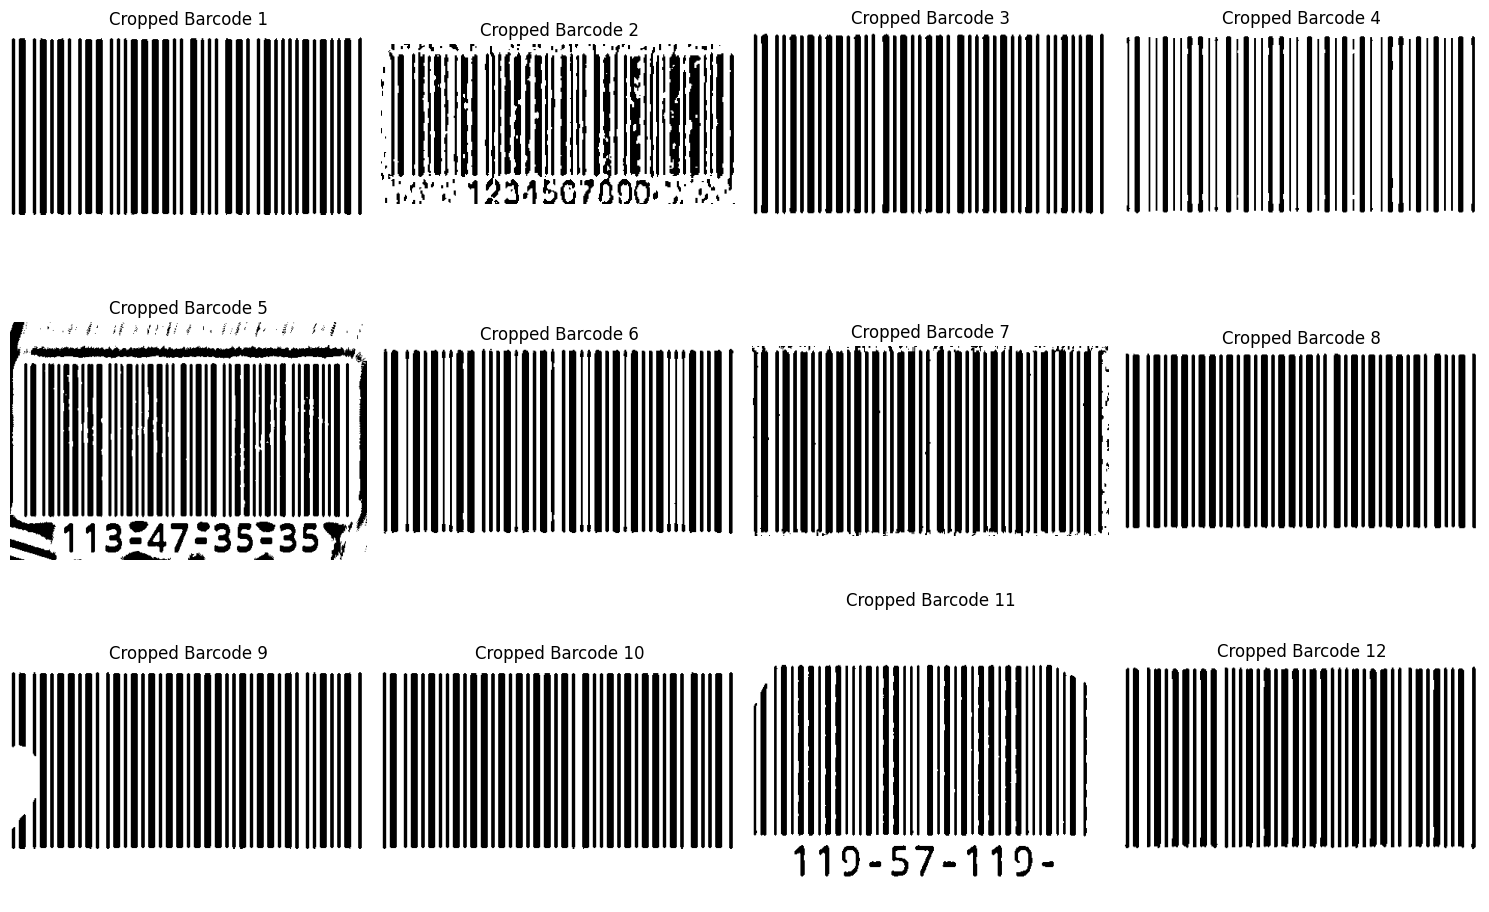

In [ ]:
# Updated detect_barcode_from_images
def detect_barcode_from_images(image_paths, fft_limit=20, fft_gaussian=True, fft_keep_dc=False):
    # Load images
    images = load_images(image_paths)

    # Convert to grayscale
    grayscale_images = convert_to_grayscale(images)

    # Remove salt-and-pepper noise
    filtered_images = remove_salt_pepper(grayscale_images)
    #display_images(filtered_images, [f"Blurred {i+1}" for i in range(len(filtered_images))], figsize=(20, 15))

    # Calculate gradients
    gradient_images = calculate_gradients(filtered_images)
    #display_images(gradient_images, [f"Gradient {i+1}" for i in range(len(gradient_images))], figsize=(25, 15))

    # Threshold images
    threshold_images_set = threshold_images(gradient_images)

    # Remove salt-and-pepper noise
    filtered_images2 = remove_salt_pepper(threshold_images_set)

    # Clean images
    cleaned_images = clean_images(filtered_images2)

    # Threshold images again
    threshold_images_set2 = threshold_images(cleaned_images)

    # Detect barcodes and get bounding boxes
    final_images, bounding_boxes, _ = detect_barcodes_with_orientation_and_axis(threshold_images_set2, images)
    #display_images(final_images, [f"final_images {i+1}" for i in range(len(final_images))], figsize=(20, 15))

    # Convert cropped barcodes to grayscale for FFT filtering
    grayscale_images2 = convert_to_grayscale(final_images)

    # remove salt and pepper
    filtered_images = remove_salt_pepper(grayscale_images2)
    #display_images(filtered_images, [f"remove_salt_pepper {i+1}" for i in range(len(filtered_images))], figsize=(20, 15))

     # Resize cropped barcodes to a consistent shape
    #resized_cropped_barcodes = resize_images(filtered_images, target_size=(256, 256))

    # Apply FFT filtering for each cropped barcode
    fft_filtered_images = try_highpass(filtered_images, fft_limit, fft_gaussian, fft_keep_dc)

    # Display FFT-filtered results
    fft_titles = [f"FFT Filtered Barcode {i+1}" for i in range(len(fft_filtered_images))]
    #display_images(fft_filtered_images, fft_titles, cols=4, figsize=(20, 10))

    #return fft_filtered_images
    #display_images(fft_filtered_images, [f"FFT Filtered Barcode {i+1}" if img is not None else f"No Barcode {i+1}" for img in fft_filtered_images])

    #return fft_filtered_images
    # Normalize and convert FFT-filtered images to uint8 before thresholding
    fft_filtered_images_normalized = [
        cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        for img in fft_filtered_images
    ]
    filtered_images_titles = [
        f"fft_filtered_images_normalized {i+1}" for i in range(len(fft_filtered_images_normalized))
    ]
    #display_images(fft_filtered_images_normalized, filtered_images_titles)
    # Pass the normalized images to the thresholding function
    threshold_images_set2 = threshold_images1(fft_filtered_images_normalized)


    # Display thresholded results
    #display_images(threshold_images_set2, [f"Last threshold {i+1}" for i in range(len(threshold_images_set2))],cols=4, figsize=(20, 15))

    # Crop barcodes using bounding box coordinates
    cropped_barcodes = crop_barcodes(threshold_images_set2, bounding_boxes)
    cropped_titles = [f"Cropped Barcode {i+1}" if crop is not None else f"No Barcode {i+1}" for i, crop in enumerate(cropped_barcodes)]
    display_images([crop for crop in cropped_barcodes if crop is not None], cropped_titles)

    return cropped_barcodes

# Run the pipeline
preprocessed = detect_barcode_from_images(image_paths, fft_limit=20, fft_gaussian=True, fft_keep_dc=True)

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

# Code 11 encoding table
code11_encoding = {
    "00110": "Start/Stop",  # Start/Stop symbol pattern
    "10001": "1",
    "01001": "2",
    "11000": "3",
    "00101": "4",
    "10100": "5",
    "01100": "6",
    "00011": "7",
    "10010": "8",
    "10000": "9",
    "00001": "0",
    "00100": "-"  # Dash symbol
}

def classify_widths(bar_space_widths):
    """Classify bar and space widths into narrow and wide categories using clustering."""
    # Reshape data for clustering
    widths = np.array(bar_space_widths).reshape(-1, 1)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(widths)
    narrow, wide = sorted(kmeans.cluster_centers_.flatten())
    print(f"Narrow: {narrow}, Wide: {wide}")
    return int(round(narrow)), int(round(wide))

def detect_bar_widths(image):
    """Detect bar and space widths in the barcode image."""
    num_cols = image.shape[1]
    bar_space_widths = []
    current_width = 1
    is_bar = image[:, 0].mean() < 128  # Start with bar if first column is black

    for col in range(1, num_cols):
        column_is_bar = image[:, col].mean() < 128
        if column_is_bar == is_bar:
            current_width += 1
        else:
            bar_space_widths.append(current_width)
            current_width = 1
            is_bar = column_is_bar

    bar_space_widths.append(current_width)
    return bar_space_widths

def decode_barcode(bar_space_widths):
    """Decode the barcode using the narrow and wide bar/space classification."""
    # Classify narrow and wide bars using clustering
    try:
        narrow, wide = classify_widths(bar_space_widths)
    except ValueError:
        return "Error: Clustering failed."

    # Set tolerances
    tolerance_narrow = narrow * 0.5
    tolerance_wide = wide * 0.5
    print(f"Narrow Tolerance: {tolerance_narrow}, Wide Tolerance: {tolerance_wide}")

    # Convert widths to binary pattern
    binary_pattern = ""
    for width in bar_space_widths:
        if abs(width - narrow) <= tolerance_narrow:
            binary_pattern += "0"
        elif abs(width - wide) <= tolerance_wide:
            binary_pattern += "1"
        elif abs(width) >= wide:
            binary_pattern += "1"
        elif abs(width) <= narrow:
            binary_pattern += "0"

        else:
            return f"Error: Width {width} not matching narrow ({narrow}) or wide ({wide})."

    print(f"Binary Pattern: {binary_pattern}")

    # Process the binary pattern by taking 5 bits at a time, skipping one bit after each chunk
    decoded_message = []
    current_pattern = ""
    started = False  # Flag to start decoding
    i = 1  # Start at the second bit (skip the very first bit)

    while i + 4 < len(binary_pattern):  # Ensure we have 5 bits to process
        # Take the next 5 bits
        current_pattern = binary_pattern[i:i+5]

        if current_pattern == "00110" and not started:  # Start pattern
            started = True  # Begin decoding after "Start"
            i += 6  # Skip the first 5 bits "Start"
            continue

        elif started:
            if current_pattern in code11_encoding:
                decoded_message.append(code11_encoding[current_pattern])
            else:
                # Append error message but continue decoding
                decoded_message.append(f"Error: Invalid pattern {current_pattern}")

        # Skip the next bit after processing 5 bits
        i += 6  # Move to the next set of 5 bits (skip 1 bit)

    if not decoded_message:
        return "Error: Unable to decode any characters."

    # Ensure the message ends with "Stop" symbol
    if decoded_message[-1] != "Start/Stop":
        decoded_message.append("Error: Missing or invalid Stop symbol.")  # Add a message if the Stop symbol is not found.

    # Return the decoded message
    return "".join(decoded_message)

def process_barcode_image(cropped_barcodes):
    """Process the barcode image to detect and decode the barcode message."""
    # Step 1: Detect bar and space widths
    bar_space_widths = detect_bar_widths(cropped_barcodes)
    print("Detected bar/space widths:", bar_space_widths)

    # Step 2: Decode the barcode
    decoded_message = decode_barcode(bar_space_widths)

    return decoded_message

In [ ]:
def decode_multiple_barcodes(cropped_barcodes):
    decoded_results = []
    display_images(cropped_barcodes, [f"Cropped Barcode {i+1}" for i in range(len(cropped_barcodes))])

    for i, cropped_image in enumerate(cropped_barcodes):
        if cropped_image is None:
            print(f"Image {i + 1}: No barcode detected.")
            decoded_results.append(None)
            continue

        try:
            print(f"Decoding barcode {i + 1}...")
            # Directly pass the preprocessed image to the function
            decoded_message = process_barcode_image(cropped_image)
            decoded_results.append(decoded_message)  # Append the decoded message for each image
        except Exception as e:
            print(f"Error decoding barcode {i + 1}: {e}")
            decoded_results.append(None)

    return decoded_results  # Return the list of decoded results, not just a single variable

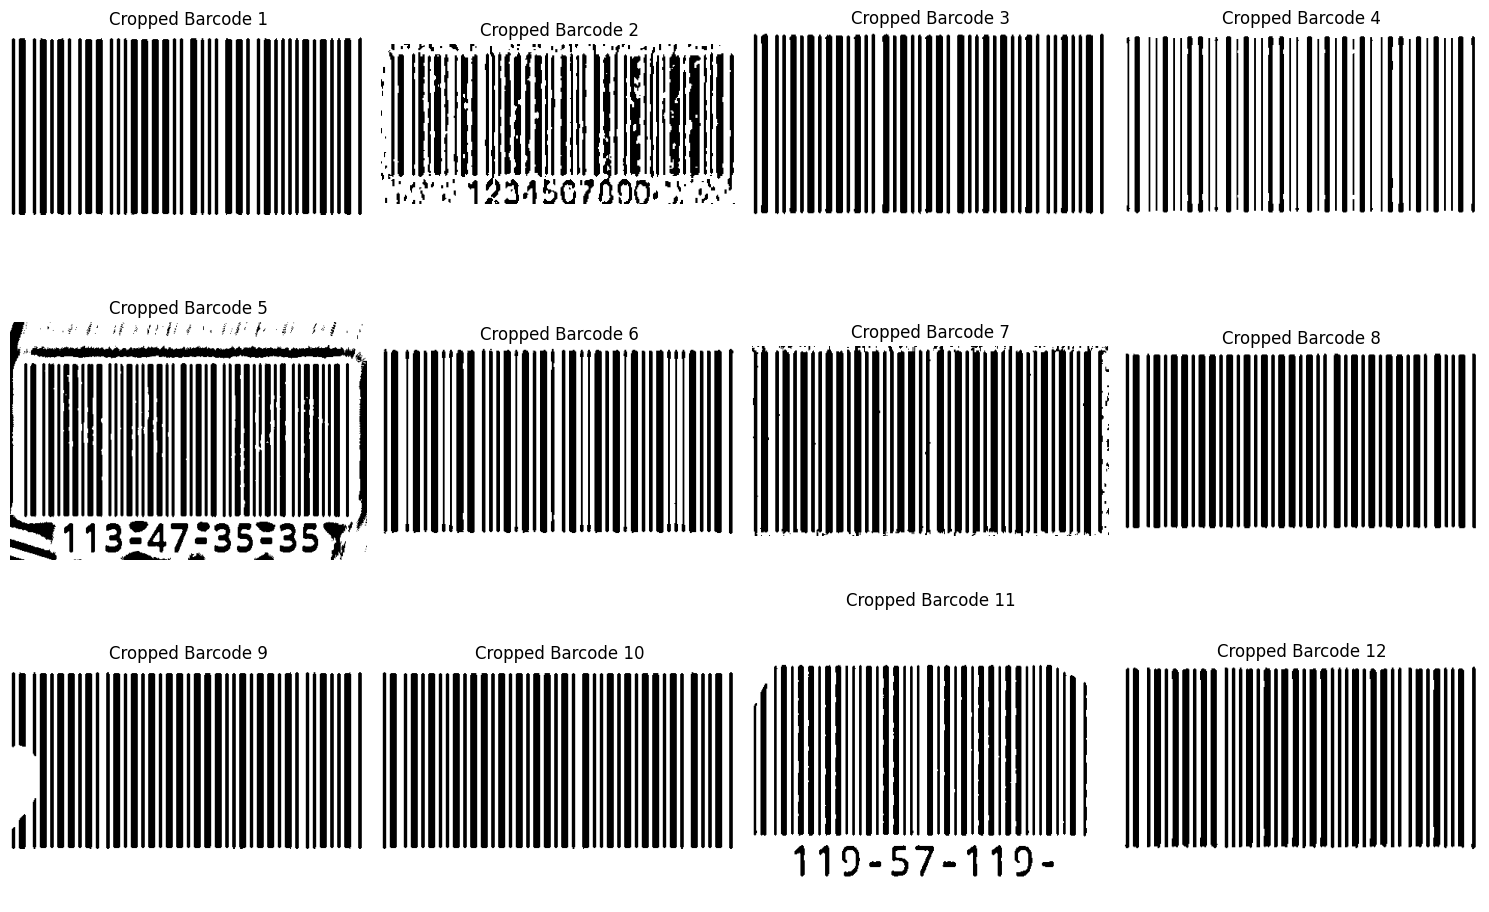

Decoding barcode 1...
Detected bar/space widths: [2, 4, 4, 8, 8, 4, 4, 8, 4, 4, 4, 8, 4, 4, 8, 4, 4, 8, 4, 8, 8, 4, 4, 4, 4, 4, 4, 8, 4, 8, 4, 8, 4, 8, 4, 4, 4, 4, 8, 8, 4, 4, 4, 4, 4, 4, 8, 8, 4, 8, 4, 4, 8, 4, 4, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 8, 4, 4, 4, 4, 4, 8, 8, 4, 6]
Narrow: 3.9636363636363643, Wide: 7.916666666666667
Narrow Tolerance: 2.0, Wide Tolerance: 4.0
Binary Pattern: 0001100100010010010110000001010101000011000000110100100100000000010001000001100
Decoding barcode 2...
Detected bar/space widths: [10, 3, 3, 6, 8, 3, 3, 5, 4, 3, 3, 7, 4, 2, 7, 2, 4, 6, 5, 5, 8, 3, 3, 3, 3, 3, 3, 5, 4, 7, 4, 5, 4, 7, 3, 3, 3, 3, 6, 6, 4, 2, 4, 2, 3, 3, 8, 6, 4, 6, 4, 3, 6, 3, 3, 9, 5, 2, 4, 2, 3, 3, 4, 2, 4, 10, 3, 3, 4, 9, 4, 2, 4, 2, 4, 7, 6, 4, 4]
Narrow: 3.372881355932202, Wide: 7.249999999999998
Narrow Tolerance: 1.5, Wide Tolerance: 3.5
Binary Pattern: 1001100100010010011110000001010101000011000000110100100110000000010001000001100
Decoding barcode 3...
Detected bar/space wi

In [ ]:
decoded_results = decode_multiple_barcodes(preprocessed)
print("decoded_results:",decoded_results)

In [ ]:
processed = apply_highpass_filter(prepossed, 20, gaussian = True, keep_dc=True)
display_images(processed, [f"Processed {i+1}" for i in range(len(processed))])

NameError: name 'prepossed' is not defined

In [ ]:
# Apply edge detection to preserve barcode edges (Canny edge detection)
    edge_detected_images = []
    for crop in cropped_barcodes:
        if crop is not None:
            # Canny edge detection
            edges = cv2.Canny(crop, threshold1=100, threshold2=200)

            # Store edge-detected images
            edge_detected_images.append(edges)

    # Display or return the edge-detected images
    edge_titles = [f"Edge Detected Barcode {i+1}" for i in range(len(edge_detected_images))]
    display_images(edge_detected_images, edge_titles)

# Now, apply vertical line filtering using Sobel operator
    vertical_edge_images = []
    for edges in edge_detected_images:
        if edges is not None:
            # Apply Sobel operator to detect vertical edges
            sobel_x = cv2.Sobel(edges, cv2.CV_64F, 1, 0, ksize=3)  # Vertical edges (X direction)
            sobel_x = np.abs(sobel_x)  # Take absolute value to remove negative values

            # Convert to uint8
            sobel_x = np.uint8(sobel_x)

            # Threshold to remove weak edges and keep only the strong vertical lines
            _, vertical_edges = cv2.threshold(sobel_x, 50, 255, cv2.THRESH_BINARY)

            # Clean up salt-and-pepper noise using a median filter
            vertical_edges = cv2.medianBlur(vertical_edges, 3)  # Apply a median filter to reduce noise

            # Optional: Use morphological operations to further clean up the vertical edges
            kernel_vertical = np.ones((1, 1), np.uint8)  # A vertical kernel for morphological operations
            vertical_edges_cleaned = cv2.morphologyEx(vertical_edges, cv2.MORPH_CLOSE, kernel_vertical)

            # Store the cleaned vertical edges
            vertical_edge_images.append(vertical_edges_cleaned)

    # Display the vertical edges detected
    vertical_titles = [f"Cleaned Vertical Edges {i+1}" for i in range(len(vertical_edge_images))]
    display_images(vertical_edge_images, vertical_titles)
